In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
from matplotlib import colors
from time import time
import os 
%matplotlib widget

from jax.lib import xla_bridge
yourdevice = xla_bridge.get_backend().platform
print(f"You are running on {yourdevice}.")

You are running on gpu.


In [2]:
# import starred stuff
from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.deconvolution.loss import Loss, Prior
from starred.optim.optimization import Optimizer
from starred.deconvolution.parameters import ParametersDeconv
from starred.utils.noise_utils import propagate_noise
from starred.plots.plot_function import view_deconv_model, plot_loss

## Tune background and image positions with best seeing frames

In [3]:
# get data
decfile = 'stamps-noisemaps-psfs.h5'
# first image is a duplicate of ref image in cosmouline, remove it:
noref = 1
# repeating dataset to increase its size
rep = 1
# stop at this number to use a smaller number of epochs in the deconvolution:
sample = 10000
# (10000 to make sure we select all of them)
paper_style = True
#to make nice plot for the paper (but it is slower)

output = './results'
os.makedirs(output, exist_ok=True)

def getData(decfile, rep, samples=10000, padding=0):
    with h5py.File(decfile, 'r') as f:
        data = np.array(f['stamps'])
        noisemap = np.array(f['noisemaps'])
        s = np.array(f['psfs'])
    
    im_size = data.shape[1]
    im_size_up = s.shape[1]
    subsampling_factor = im_size_up // im_size
    
    data = data[noref:samples]
    s = s[noref:samples]
    noisemap = noisemap[noref:samples]

    epochs = data.shape[0]

    #PAD DATA
    assert padding%2 == 0, "Padding by odd number is impossible." 
    if padding > 0: 
        new_data = np.zeros((epochs, im_size+padding, im_size+padding))
        new_noisemap = np.ones((epochs, im_size+padding, im_size+padding)) * np.mean(noisemap)
        margin = int(padding/2)

        new_data[:, margin:-margin, margin:-margin] = data
        new_noisemap[:, margin:-margin, margin:-margin] = noisemap
    
    else: 
        new_data = data 
        new_noisemap = noisemap
    
    # REPEAT DATA
    data = np.vstack(rep*[new_data])
    s = np.vstack(rep*[s])
    noisemap = np.vstack(rep*[new_noisemap])
    
    epochs = data.shape[0]
    im_size = data.shape[1]
    im_size_up = im_size * subsampling_factor
    
    return data, noisemap, s, (im_size, im_size_up, subsampling_factor, epochs)


def run_deconv(data, noisemap, s):
    t0 = time()
    #Renormalise your data and the noise maps by the max of the first image. Works better when using adabelief
    norm = data[0].max() / 100.
    data /= norm
    noisemap /= norm 

    nepoch, im_size, _ = np.shape(data)
    # image positions (read these from a matplotlib plot above)
    off = (im_size - 1) / 2. # removing (im_size-1) / 2 because starred has (0,0) = center of image

    # xs = np.array([14.3, 11.55,12.46, 18.55]) - off
    # ys = np.array([21.12, 18.34, 13.60, 17.50]) - off

    xs =  np.array([-1.6058782, -3.9724423, -3.098422 ,  2.8664386]) 
    ys =  np.array([5.3804007,  3.350775 , -1.7827529,  1.6528895] )

    # intensity per point:
    # adjust these from running this cell iteratively
    amps = np.asarray([30000, 10000, 7000, 5000] * nepoch) / norm

    model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, noisemap**2, s, xs, ys, subsampling_factor,initial_a=amps)
    W = propagate_noise(model, noisemap, kwargs_init, wavelet_type_list=['starlet'], 
                    method='MC', num_samples=500, seed=1, likelihood_type='chi2', 
                    verbose=False, upsampling_factor=subsampling_factor)[0]

    parameters = ParametersDeconv(kwargs_init, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)
    args_init = parameters.kwargs2args(kwargs_init)

    prior_astrom = Prior(prior_analytic=[['c_x',xs ,0.25], ['c_y',ys , 0.25]], prior_background=None)

    loss = Loss(data, model, parameters, noisemap**2, 
                regularization_terms='l1_starlet', 
                regularization_strength_scales=0.1, 
                regularization_strength_hf=0.3, W=W, prior=prior_astrom) 

    #
    optim = Optimizer(loss, parameters, method='adabelief')

    optimiser_optax_option = {
                                'max_iterations':200, 'min_iterations':None,
                                'init_learning_rate':1e-1, 'schedule_learning_rate':True,
                                'restart_from_init':True, 'stop_at_loss_increase':False,
                                'progress_bar':True, 'return_param_history':True
                            }  

    t1 = time()
    tc1 = time()
    _ = optim.value_and_gradient(args_init)
    compile_time = time() - tc1 

    tc2 = time()
    for i in range(10):
        _ = optim.value_and_gradient(args_init)
    loss_grad_time = (time() - tc2) /10.
    
    best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)
    t2 = time()
    kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))

    total_runtime = t2-t0
    prep_runtime = t1-t0
    iter_runtime = t2-t1

    return model, kwargs_final, kwargs_init, extra_fields, total_runtime, prep_runtime, iter_runtime, compile_time, loss_grad_time
    

In [4]:
data, noisemap, s, (im_size, im_size_up, subsampling_factor, epochs) = getData(decfile, rep, padding=0)
print(np.shape(data))
model, kwargs_final, kwargs_init, extra_fields, total_runtime, prep_runtime, iter_runtime, compile_time, loss_grad_time = run_deconv(data, noisemap, s)


(104, 32, 32)


optax.adabelief: 100%|████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.41it/s]


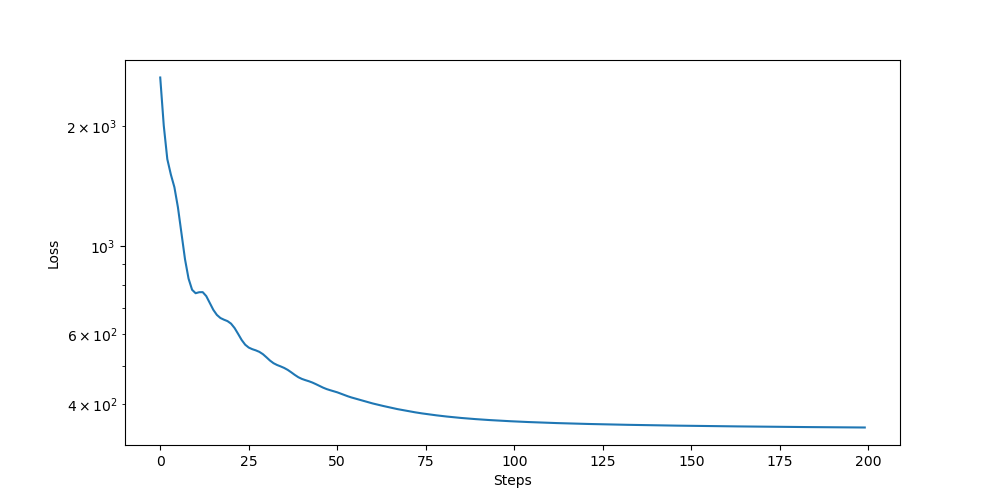

In [5]:
fig = plot_loss(extra_fields['loss_history'])

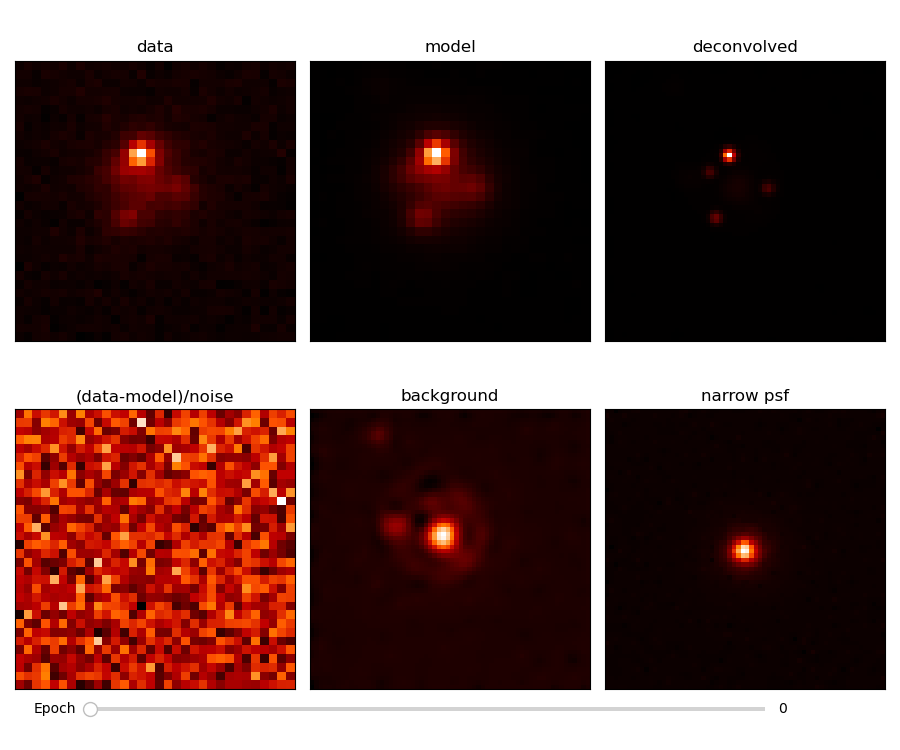

In [6]:
view_deconv_model(model, kwargs_final, data, noisemap**2)

In [7]:
print(f"shape of data:", data.shape)
print(f"TOTAL TIME: {total_runtime:.01f} seconds")
print(f"Time spent iterating: {iter_runtime:.01f} seconds")
print(f"Time for model setup and deconv without iterations: {prep_runtime:.01f} seconds")
print(f"Time for model compilation: {compile_time:.01f} seconds")
print(f"Time for LogL and gradient evaluation: {loss_grad_time:.03f} seconds")

# Expected time on Martin's laptop (CPU): 
# shape of data: (104, 32, 32)
# TOTAL TIME: 71.3 seconds
# Time spent iterating: 67.5 seconds
# Time for model setup and deconv without iterations: 3.9 seconds
# Time for model compilation: 6.1 seconds
# Time for LogL and gradient evaluation: 0.272 seconds


shape of data: (104, 32, 32)
TOTAL TIME: 11.2 seconds
Time spent iterating: 8.8 seconds
Time for model setup and deconv without iterations: 2.3 seconds
Time for model compilation: 5.0 seconds
Time for LogL and gradient evaluation: 0.033 seconds


# Loop over number of epochs.

In [10]:
if yourdevice == 'gpu': 
    rep = [1,1,1,1,1,2,4,8,16]
    samples = [11,21,41,81,101, 10000, 10000, 10000, 10000]
else: 
    rep = [1,1,1,1,1,2]
    samples = [11,21,41,81,101, 10000]

rerun = False

if not os.path.exists(os.path.join(output, '%s_time_epochs.txt'%yourdevice)) or rerun:
    total_runtime, prep_runtime, iter_runtime, nepochs, npixels, compile_runtime, lossgr = [], [], [], [], [], [], []

    for r,s in zip(rep, samples): 
        data, noisemap, s,  vec_size= getData(decfile, r, samples=s)
        im_size, im_size_up, subsampling_factor, epochs = vec_size
        print(vec_size)
        model, kwargs_final, kwargs_init, extra_fields, tr, pr, ir, cr, lgr = run_deconv(data, noisemap, s)
        # tr, pr, ir, cr, lgr = 1., 1. ,1. , 1., 1.
        total_runtime.append(tr)
        prep_runtime.append(pr) 
        iter_runtime.append(ir)
        nepochs.append(epochs)
        npixels.append(im_size_up**2 * epochs)
        compile_runtime.append(cr)
        lossgr.append(lgr)


    np.savetxt(os.path.join(output, '%s_time_epochs.txt'%yourdevice), [rep, samples, nepochs, npixels, total_runtime, prep_runtime, iter_runtime, compile_runtime, lossgr])



# Loop over data dimension

In [11]:
if yourdevice == 'gpu': 
    rep = [1,1,1,1,1]
    samples = [11,11,11,11,11]
    padding = [0,32,64,128,246,512]
else : 
    rep = [1,1,1,1]
    samples = [11,11,11,11]
    padding = [0,32,64,128,246]

rerun = False

if not os.path.exists(os.path.join(output, '%s_time_imsize.txt'%yourdevice)) or rerun:
    total_runtime, prep_runtime, iter_runtime, nepochs, npixels, compile_runtime, lossgr = [], [], [], [], [], [], []

    for r,s,p in zip(rep, samples, padding): 
        data, noisemap, s,  vec_size= getData(decfile, r, samples=s, padding=p)
        im_size, im_size_up, subsampling_factor, epochs = vec_size
        print(vec_size)
        model, kwargs_final, kwargs_init, extra_fields, tr, pr, ir, cr, lgr = run_deconv(data, noisemap, s)
        # tr, pr, ir, cr, lgr = 1., 1. ,1. , 1., 1.
        total_runtime.append(tr)
        prep_runtime.append(pr) 
        iter_runtime.append(ir)
        nepochs.append(epochs)
        npixels.append(im_size_up**2 * epochs)
        compile_runtime.append(cr)
        lossgr.append(lgr)


    np.savetxt(os.path.join(output, '%s_time_imsize.txt'%yourdevice), [rep, samples, nepochs, npixels, total_runtime, prep_runtime, iter_runtime, compile_runtime, lossgr])

# Plot the results

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./results/gpu_runtime_epochs.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./results/gpu_runtime_imsize.pdf'.
[0.03485203 0.03348594 0.03738272 0.03696437 0.0342905  0.03477304
 0.0352448  0.03737869 0.05084815]


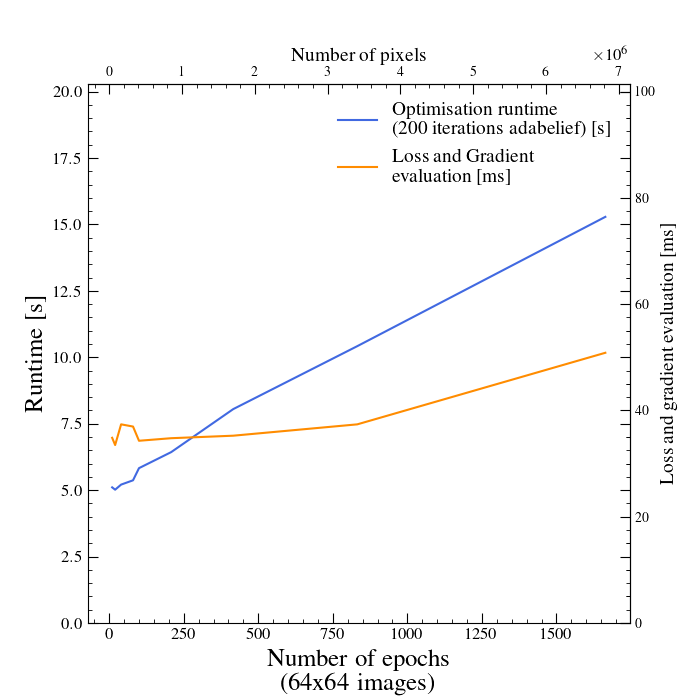

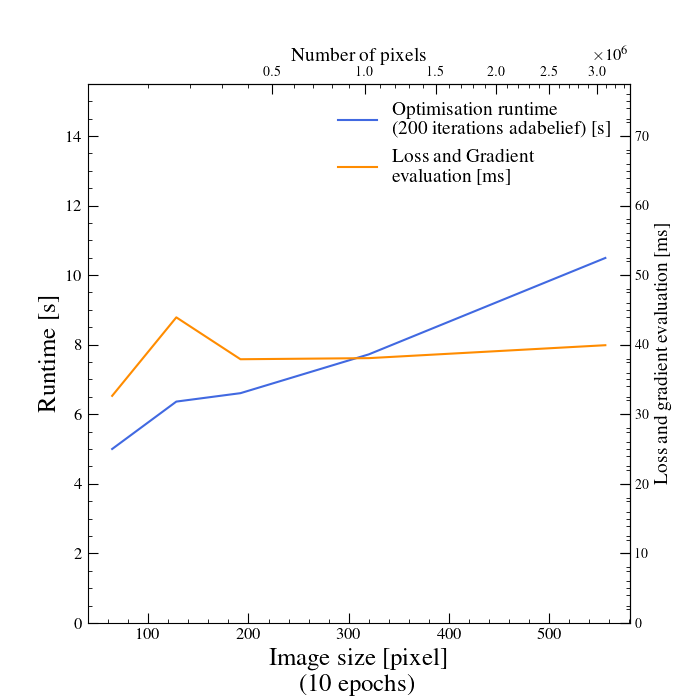

In [12]:
import matplotlib as mpl 
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
mpl.rcParams['axes.labelsize']= 18

mpl.rcParams['xtick.labelsize']= 12
mpl.rcParams['xtick.direction']= 'in'
mpl.rcParams['xtick.top']= False
mpl.rcParams['xtick.minor.visible']=  True
mpl.rcParams['xtick.major.size']=  7
mpl.rcParams['xtick.minor.size']=  3

mpl.rcParams['ytick.labelsize']=  12
mpl.rcParams['ytick.direction']= 'in'
mpl.rcParams['ytick.right']=  True
mpl.rcParams['ytick.minor.visible']=  True
mpl.rcParams['ytick.major.size']=  7
mpl.rcParams['ytick.minor.size']=  3

mpl.rcParams['legend.numpoints']=  1
mpl.rcParams['legend.facecolor']=  'None'
mpl.rcParams['legend.edgecolor']=  'None'
mpl.rcParams['legend.fontsize']=  18

if paper_style:
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = 'Times'
    mpl.rcParams['text.usetex'] = True

yourdevice = 'gpu'

rep, samples, nepochs, npixels, total_runtime, prep_runtime, iter_runtime, compile_runtime, lossgr = np.loadtxt(os.path.join(output,  '%s_time_epochs.txt'%yourdevice))
rep2, samples2, nepochs2, npixels2, total_runtime2, prep_runtime2, iter_runtime2, compile_runtime2, lossgr2 = np.loadtxt(os.path.join(output,  '%s_time_imsize.txt'%yourdevice))
subsampling_factor_base = 2 
im_size_base = 32
nepochs_base = 10
if yourdevice == 'cpu':
    dy = 30
else:
    dy = 5

plt.close('all')
fig1, ax1 = plt.subplots(1,1,figsize=(7,7)) 
fig2, ax2 = plt.subplots(1,1,figsize=(7,7)) 
ax1.plot(nepochs, iter_runtime, 'royalblue', label='Optimisation runtime \n (200 iterations adabelief) [s]')
ax1.plot(nepochs, lossgr*200, 'darkorange', label='Loss and Gradient \n evaluation [ms]')
ax1.set_ylim([0, max(iter_runtime)+dy])
ax1.set_ylabel('Runtime [s]')
ax1.set_xlabel('Number of epochs \n (64x64 images) ')
ax1.legend(fontsize=14)
# ax[0].legend(fontsize=14)

def forward(x):
    return (im_size_base*subsampling_factor_base)**2 * x
def inverse(y): 
    return y / (im_size_base*subsampling_factor_base)**2

def forward2(x):
    return x /200 * 1000
def inverse2(y): 
    return y* 200 /1000

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('Number of pixels', fontsize=14)
secax.tick_params(axis='x', which='major', labelsize=10)
secax.ticklabel_format(style='sci', scilimits=(0,3))

secay = ax1.secondary_yaxis('right', functions=(forward2, inverse2))
secay.set_ylabel('Loss and gradient evaluation [ms]', fontsize=14)
secay.tick_params(axis='y', which='major', labelsize=10)


ax2.plot(np.sqrt(npixels2 / nepochs2), iter_runtime2, 'royalblue', label='Optimisation runtime \n (200 iterations adabelief) [s]')
ax2.plot(np.sqrt(npixels2 / nepochs2), lossgr2 * 200, 'darkorange', label='Loss and Gradient \n evaluation [ms]')
ax2.set_ylabel('Runtime [s]')
ax2.set_ylim([0, max(iter_runtime2)+dy])
ax2.set_xlabel('Image size [pixel] \n (10 epochs)')
ax2.legend(fontsize=14)

def forward(x):
    return x**2 * nepochs_base
def inverse(y): 
    return np.sqrt(y / nepochs_base) 

secax = ax2.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('Number of pixels', fontsize=14)
secax.tick_params(axis='x', which='major', labelsize=10)

secay = ax2.secondary_yaxis('right', functions=(forward2, inverse2))
secay.set_ylabel('Loss and gradient evaluation [ms]', fontsize=14)
secay.tick_params(axis='y', which='major', labelsize=10)


# plt.tight_layout()
filename1 = os.path.join(output, '%s_runtime_epochs.pdf'%yourdevice)
filename2 = os.path.join(output, '%s_runtime_imsize.pdf'%yourdevice)
fig1.savefig(filename1, dpi = 300)
fig2.savefig(filename2, dpi = 300)

os.system(f'pdfcrop {filename1} {filename1}')
os.system(f'pdfcrop {filename2} {filename2}')

print(lossgr)


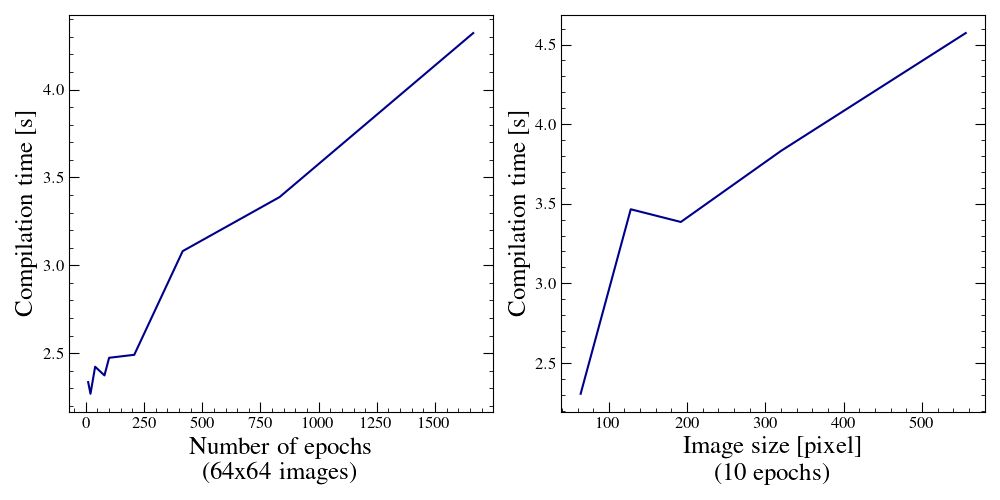

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5)) 
ax[0].plot(nepochs, compile_runtime, 'darkblue', label='Compilation time [s]')
ax[0].set_ylabel('Compilation time [s]')
ax[0].set_xlabel('Number of epochs \n (64x64 images) ')

ax[1].plot(np.sqrt(npixels2 / nepochs2), compile_runtime2, 'darkblue', label='Compilation time [s]')
ax[1].set_ylabel('Compilation time [s]')
ax[1].set_xlabel('Image size [pixel] \n (10 epochs)')

plt.tight_layout()
fig.savefig(os.path.join(output, '%s_compile_time.pdf'%yourdevice), dpi = 300)
